In [1]:
import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

from datetime import datetime, date

from scipy.misc import imresize
import features


In [2]:
def not_in_list(x,args,y):
    list = x['caption'].split(' #')
    return not (args in list[1:])

def convertString(x):
    string = str(x)
    if 'k' in string:
        number = float( ''.join(string.split('k')[0].split(',')) ) * 1000
    elif 'm' in string:
        number = float( ''.join(string.split('m')[0].split(',')) ) * 1000000
    else:
        number = float( ''.join(string.split(',')) )
    return number

def extractTimeData(x):
    createdtime = datetime.fromtimestamp(int(x))
    hour = createdtime.hour
    weekday = createdtime.weekday()
    #date(2017,9,16).weekday()
    return weekday, hour

In [3]:
import utils
import json
import pandas
import features
from scipy.misc import imresize

In [4]:
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S

In [46]:
posts,images = utils.dataFromScraper('hungrygrls')
dfp = pandas.DataFrame(posts)

In [55]:
# Extract image features

nbins = 20
nposts0 = len(posts)
satH = np.zeros([nposts0,nbins])
conH = np.zeros([len(posts),nbins])
sat = np.zeros(len(posts))
contrast = np.zeros(len(posts))

dims = 5
comp = np.zeros([len(posts),dims**2])

kernelCos,kernelSin,kernelCor1,kernelCor2,kernelCor3,kernelCor4 = features.compKernels(dims)
kCos = np.zeros(nposts0)
kSin = np.zeros(nposts0)
kCor1 = np.zeros(nposts0)
kCor2 = np.zeros(nposts0)
kCor3 = np.zeros(nposts0)
kCor4 = np.zeros(nposts0)

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2))
    sat[i] = np.mean(features.colorfulness(images[i]))
    intensity = np.mean(images[i],2)
    conH[i],_ = np.histogram(intensity, bins=nbins)
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])

    temp = imresize(intensity,[dims,dims])
    kCos[i] = np.mean(temp*kernelCos)
    kSin[i] = np.mean(temp*kernelSin)
    kCor1[i] = np.mean(temp*kernelCor1)
    kCor2[i] = np.mean(temp*kernelCor2)
    kCor3[i] = np.mean(temp*kernelCor3)
    kCor4[i] = np.mean(temp*kernelCor4)
    

# Extract features

likes = dfp['likes'].apply(lambda x: float(convertString(x))).values
ntags = dfp[u'caption'].apply(lambda x: float( len(x.split(' #')) ) ).values - 1
hour = dfp[u'createdtime'].apply(lambda x: extractTimeData(x)[1]).values
weekday = dfp[u'createdtime'].apply(lambda x: extractTimeData(x)[0]).values


In [ ]:
# Normalize data

minsat = np.min(sat)
maxsat = np.max(sat)
mincon = np.min(contrast)
maxcon = np.max(contrast)
minlike = min(likes)
maxlike = max(likes)
mintags = min(ntags)
maxtags = max(ntags)

normSinA = np.abs(kSin)/np.max(np.abs(kSin))

normsat = (sat - minsat)/(maxsat-minsat)
normcontrast = (contrast - mincon)/(maxcon-mincon)
normlikes = (likes - minlike)/(maxlike - minlike)
normcomp = comp/255.
normNtags = (ntags - np.mean(ntags))/(maxtags - mintags)
normCos = (kCos - np.mean(kCos))/(np.max(kCos) - np.min(kCos))
normSin = (kSin - np.mean(kSin))/(np.max(kSin) - np.min(kSin))


# Vectorize data

data = np.zeros([nposts0,1+2+4+1+1+1])
data[:,0] = normCos
data[:,1] = normSin
data[:,2] = normSinA
data[:,3] = kCor1/np.max(kCor1)
data[:,4] = kCor2/np.max(kCor2)
data[:,5] = kCor3/np.max(kCor3)
data[:,6] = kCor4/np.max(kCor4)
data[:,7] = normsat
data[:,8] = normcontrast
data[:,-1] = normNtags


(1342,)
MSE: 0.028361
R2S: 0.006307


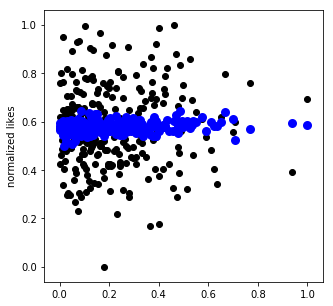

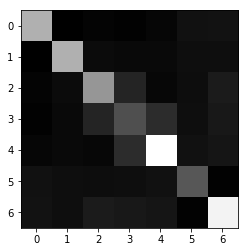

[  5.33128670e-04   9.44544394e-05   1.67331928e-03   1.22161144e-03
   8.57420380e-04  -1.37174601e-03   2.75250883e-02]


In [49]:
# Prune data
    
keep = (likes < 2000) & (likes > 1) #& (ntags < 18)
#keep = dfp.apply(not_in_list,args=[u'fashion',0],axis=1).values & keep

goodData = data[keep,:]


# Split into test and training sets

nposts = len(goodData)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
crossval = ((np.arange(nposts) % 10) == 1) | ((np.arange(nposts) % 10) == 5)
train = np.logical_not(test) & np.logical_not(crossval)
ntrain = len(np.where(train)[0])
ncross = len(np.where(crossval)[0])

if False:
    data_train = np.zeros([ntrain,(1+2+4+4+1+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,1] = gCos[train]
    data_train[:,2] = gSin[train]
    data_train[:,3:7] = gcomp[train,:4]
    data_train[:,7:11] = gcomp[train,-4:]
    data_train[:,11] = goodcontrast[train]
    data_train[:,-1] = ntags[train]

    data_test = np.zeros([(nposts-ntrain),(1+2+4+4+1+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,1] = gCos[test]
    data_test[:,2] = gSin[test]
    data_test[:,3:7] = gcomp[test,:4]
    data_test[:,7:11] = gcomp[test,-4:]
    data_test[:,11] = goodcontrast[test]
    data_test[:,-1] = ntags[test]

elif True:
    data_train = np.zeros([ntrain,1+2+1+1+1])
    data_train[:,0] = gCos[train]
    data_train[:,1] = gSin[train]
    data_train[:,2] = goodsat[train]
    data_train[:,3] = goodcontrast[train]
    data_train[:,-2] = gSinA[train]
    data_train[:,-1] = ntags[train]
    
    data_test = np.zeros([(nposts-ntrain),1+2+1+1+1])
    data_test[:,0] = gCos[test]
    data_test[:,1] = gSin[test]
    data_test[:,2] = goodsat[test]
    data_test[:,3] = goodcontrast[test]
    data_test[:,-2] = gSinA[test]
    data_test[:,-1] = ntags[test]
    
elif False:
    data_train = np.zeros([ntrain,1+1+1])
    data_train[:,0] = gCos[train]
    data_train[:,1] = gSin[train]
    data_train[:,-1] = ntags[train]
    
    data_test = np.zeros([(nposts-ntrain),1+1+1])
    data_test[:,0] = gCos[test]
    data_test[:,1] = gSin[test]
    data_test[:,-1] = ntags[test]
    
elif True:
    data_train = np.zeros([ntrain,1])
    data_train[:,-1] = ntags[train]
    
    data_test = np.zeros([(nposts-ntrain),1])
    data_test[:,-1] = ntags[test]
    
elif False:
    data_train = np.zeros([ntrain,(1+20+25+1)])
    data_train[:,0] = goodsat[train]
    data_train[:,1:21] = goodcontrast[train,:]
    data_train[:,21:46] = gcomp[train]
    #data_train[:,7:11] = gcomp[train,-4:]
    data_train[:,-1] = ntags[train]

    data_test = np.zeros([(nposts-ntrain),(1+20+25+1)])
    data_test[:,0] = goodsat[test]
    data_test[:,1:21] = goodcontrast[test,:]
    data_test[:,21:46] = gcomp[test]
    #data_test[:,7:11] = gcomp[test,-4:]
    data_test[:,-1] = ntags[test]

elif True:
    data_train = np.zeros([ntrain,(25+20+1)])
    data_train[:,0:25] = gcomp[train,:]
    data_train[:,25:-1] = goodcontrast[train]
    data_train[:,-1] = goodsat[train]

    data_test = np.zeros([(nposts-ntrain),(25+20+1)])
    data_test[:,0:25] = gcomp[test,:]
    data_test[:,25:-1] = goodcontrast[test]
    data_test[:,-1] = goodsat[test]

    
y_train = likes[train]
y_test = likes[test]


# Run regression

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_test)

print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)

fig = plt.figure(figsize=[5,5])
feat = -2
plt.scatter(data_test[:,feat], y_test,  color='black')
plt.scatter(data_test[:,feat], y_pred, color='blue', linewidth=3)
#plt.xlabel('normalized contrast')
plt.ylabel('normalized likes')
plt.show()

cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
plt.imshow(cov,cmap='gray')
plt.show()
print cov[-1,:] #, data_test[1,:]


In [50]:
imagesG = np.mean(images,3)

plt.scatter(ntags,likes)

likes = likes/np.max(likes)

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(141)
keep = (likes > .3)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax1.imshow(image/255.)

ax2 = fig.add_subplot(142)
keep = (likes > .25) & (likes <= .4)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax2.imshow(image/255.)

ax3 = fig.add_subplot(143)
keep = (likes > .2) & (likes <= .25)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax3.imshow(image/255.)

ax4 = fig.add_subplot(144)
keep = (likes <= .2)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax4.imshow(image/255.)

#plt.show()

(1289,)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1456 but corresponding boolean dimension is 1342